In [1]:
from datasets.coco_dataset import CocoDataset
import albumentations as A
from albumentations.pytorch.transforms import ToTensor
import random
import numpy as np
import matplotlib.pyplot as plt
from augmentations.transforms import get_augmentation
from configs import Config

In [2]:
config = Config('./configs/vinai512.yaml')

In [3]:
transforms = get_augmentation(config, _type='train')

In [7]:
dataset = CocoDataset(
    config=config,
    root_dir = 'datasets/vinai512-original/images/train',
    ann_path = 'datasets/vinai512-original/annotations/wbf512_ratio_fold0_train.json',
    transforms = transforms,
    train=True
)

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


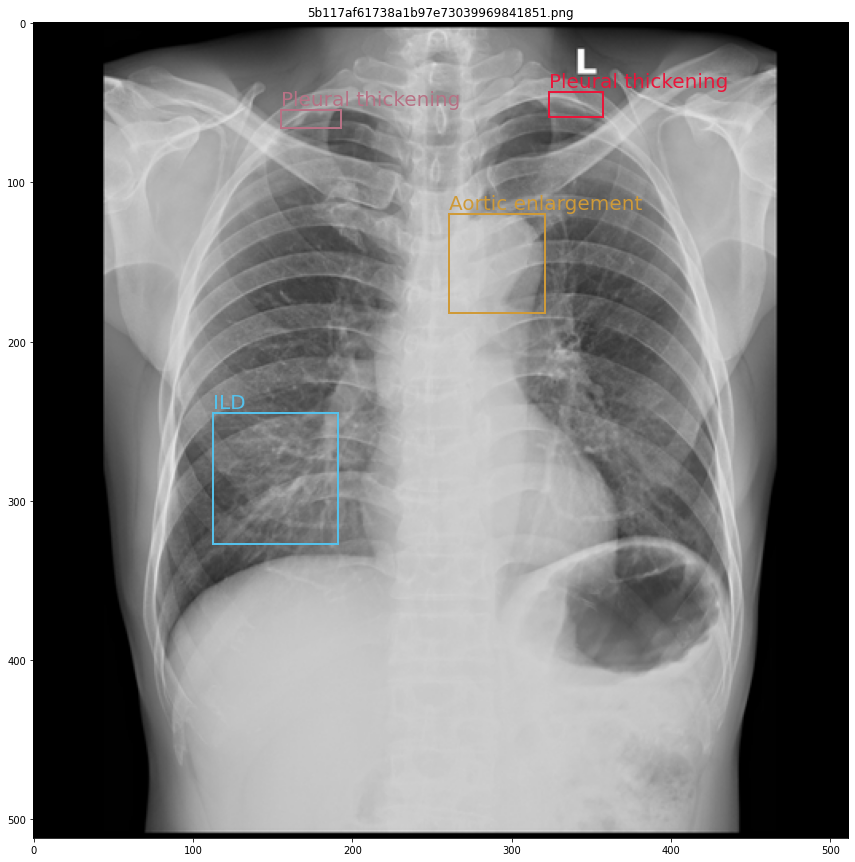

In [9]:
%matplotlib inline
dataset.visualize_item()